In [1]:
# note: fdfdpy and nonlinear_avm must be in PATH
from fdfdpy.Fdfd import Fdfd
from optimization import run_optimization
from optimization_class import Optimization
from structures import three_port

import numpy as np
import matplotlib.pylab as plt
import scipy.sparse as sp

%load_ext autoreload
%autoreload 2
%matplotlib inline

/home/momchil/anaconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/momchil/anaconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [5]:
lambda0 = 2e-6
c0 = 3e8
omega = 2*np.pi*c0/lambda0  # angular frequency (2pi)
dl = 1e-1                   # grid size (L0)
Nx = 80
Ny = 50
nx, ny = int(Nx/2), int(Ny/2)
shape = (Nx,Ny)           # shape of domain (in grids)
NPML = [10, 10]             # number of pml grid points on x and y borders
pol = 'Ez'                  # polarization (either 'Hz' or 'Ez')

In [6]:
# define the two port parameters
L = 3
H = 3
w = .2
d = 1.5
eps_m = 5

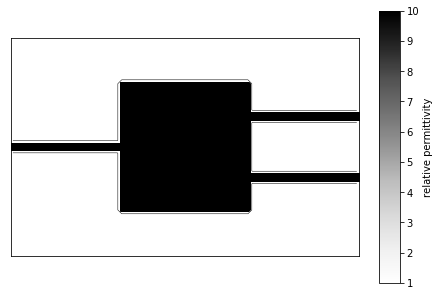

In [7]:
# define permittivity of three port system
eps_r = three_port(L, H, w, d, dl, shape, eps_start=10)
simulation = Fdfd(omega,eps_r,dl,NPML,pol)
simulation.plt_eps()

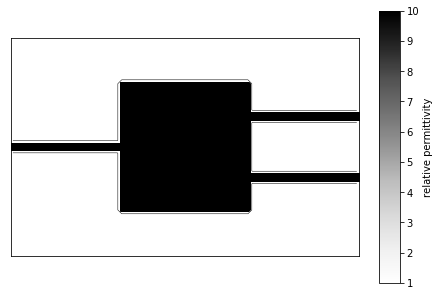

In [8]:
# set the modal source and probes

# simulation to solve
simulation = Fdfd(omega, eps_r, dl, NPML, 'Ez')
simulation.add_mode(3.5, 'x', [15, ny], int(d/dl))
simulation.setup_modes()
simulation.src = simulation.src*40

# top modal profile (kind of a hack, could be nice to get this without making a simulation())
top = Fdfd(omega, eps_r, dl, NPML, 'Ez')
top.add_mode(3.5, 'x', [Nx-15, ny+int(d/2/dl)], int(d/dl))
top.setup_modes()
J_top = np.abs(top.src)  # sometimes negative and sometimes positive. So I just abs it for consistency

# bottom modal profile
bot = Fdfd(omega, eps_r, dl, NPML, 'Ez')
bot.add_mode(3.5, 'x', [Nx-15, ny-int(d/2/dl)], int(d/dl))
bot.setup_modes()
J_bot = np.abs(bot.src)

simulation.plt_eps()

In [9]:
# set source and solve for electromagnetic fields
print(d/dl)
(Hx,Hy,Ez) = simulation.solve_fields()

15.0


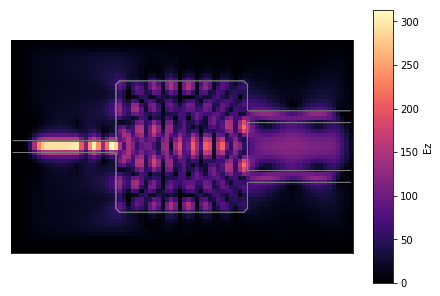

In [11]:
# plot linear field
simulation.plt_abs(outline=True, cbar=True);

In [12]:
# Define some parameters for the optimization
eps_max = 5
Nsteps = 100
Jregion = np.zeros(eps_r.shape)
Jregion[Nx-15, ny+int(d/2/dl)] = 1
Jregion_nl = np.zeros(eps_r.shape)
Jregion_nl[Nx-15, ny-int(d/2/dl)] = 1
chi3 = 2.8*1e-18                           # Silcion in m^2/V^2 from Boyd's book
chi3_fdfd = chi3/simulation.L0**2          # In the units of the FDFD solver such that eps_nl = eps_r + 3*chi3_fdfd*|e|^2

## Purely Linear

## Both Linear and Nonlinear

In [13]:
# define linear and nonlinear parts of objective function + the total objective function form
J = {}
J['linear']    = lambda e: np.sum(np.square(np.abs(e*J_top)))
J['nonlinear'] = lambda e: np.sum(np.square(np.abs(e*J_bot)))
J['total']     = lambda J_lin, J_nonlin: J_lin + J_nonlin

# define linear and nonlinear parts of dJdE + the total derivative form
dJdE = {}
dJdE['linear']    = lambda e: np.conj(e)*J_top
dJdE['nonlinear'] = lambda e: np.conj(e)*J_bot
dJdE['total']     = lambda dJdE_lin, dJdE_nonlin: dJdE_lin + dJdE_nonlin

# define the design and nonlinear regions
design_region = np.array(eps_r > 1).astype(int)
design_region[:nx-int(L/2/dl),:] = 0
design_region[nx+int(L/2/dl):,:] = 0
regions = {}
regions['design'] = design_region
regions['nonlin'] = design_region

# define the nonlinearity
kerr_nonlinearity = lambda e: 3*chi3_fdfd*np.square(np.abs(e))
kerr_nl_de = lambda e: 3*chi3_fdfd*np.conj(e)
nonlin_fns = {}
nonlin_fns['deps_de'] = kerr_nonlinearity
nonlin_fns['dnl_de'] = kerr_nl_de

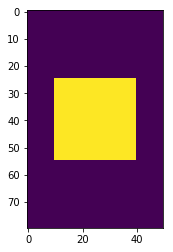

In [14]:
plt.imshow(design_region)

In [15]:
simulation.reset_eps(eps_r)

# initialize an optimization object with the optimization-specific parameters
opt_both = Optimization(Nsteps=2800, J=J, dJdE=dJdE, eps_max=5, step_size=.00005, solver='newton', opt_method='descent')

# run that optimization with the simulation and your objective function stuff
(new_eps, obj_fns) = opt_both.run(simulation, regions=regions, nonlin_fns=nonlin_fns)

100% (2800 of 2800) |####################| Elapsed Time: 0:28:40 ETA:  00:00:00

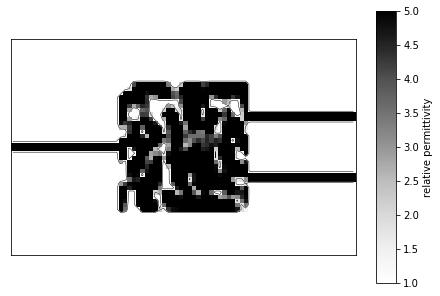

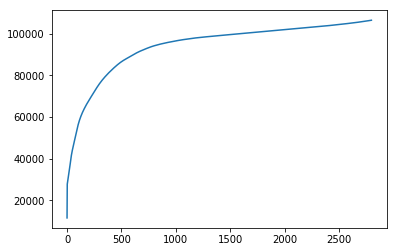

In [16]:
simulation.plt_eps()
plt.show()
plt.plot(obj_fns)
plt.show()

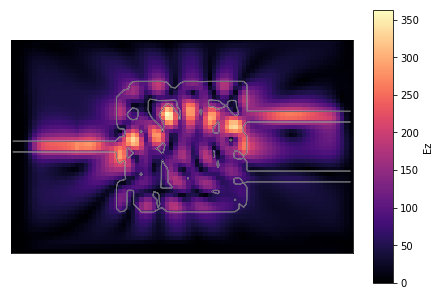

In [17]:
# compare the nonlinear and linear fields
(Hx,Hy,Ez) = simulation.solve_fields()
simulation.plt_abs()

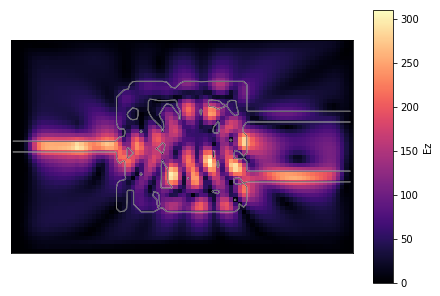

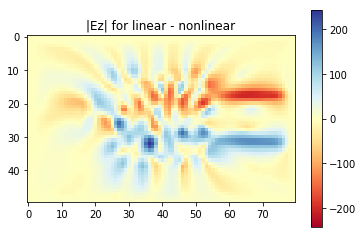

In [18]:
(Hx_nl,Hy_nl,Ez_nl,_) = simulation.solve_fields_nl(nonlin_fns['deps_de'], regions['nonlin'],
                                                   dnl_de=kerr_nl_de,solver_nl='newton')
simulation.plt_abs()
plt.show()
difference = np.abs(Ez).T - np.abs(Ez_nl).T
plt.imshow(difference, vmin=-np.max(difference), vmax=np.max(difference), cmap='RdYlBu')
plt.colorbar()
plt.title('|Ez| for linear - nonlinear')
plt.show()


# Adam Optimization

You can now include `opt_method = 'adam'` (default) or `opt_method = 'descent'` when you create an optimization object and define whether to use Adam or vanilla gradient descent. 
 
Note: Adam is scale-invariant in the sense that the step size is independent of the normalization of the objective function. In the example above using gradient descent, the step size needed to be very small because the objective function (and hence the gradient) is very large. With Adam, regardless of the objective function, the update to all parameters is of the order of the step_size. Since eps_r is between 1 and 5, a step size of 0.1-0.01 should be fine. 

Note: In the example below, even step_size = 0.1 works very well in the beginning. However, in the end, when the simulation starts diverging occasionally, a smaller step size helps, hence I used 0.04.

Note: The simulation starts diverging only for values of the objective function that are *above* the values reached during the gradient descent above. The divergence is thus *not* because of Adam. 

In [72]:
simulation.reset_eps(eps_r)

# initialize an optimization object with the optimization-specific parameters
opt_both = Optimization(Nsteps=400, J=J, dJdE=dJdE, eps_max=5, step_size=.04, solver='newton', opt_method='adam')

# run that optimization with the simulation and your objective function stuff
(new_eps, obj_fns) = opt_both.run(simulation, regions=regions, nonlin_fns=nonlin_fns)

 86% (344 of 400) |##################    | Elapsed Time: 0:03:09 ETA:   0:02:32

the simulation did not converge, reached 0.08915675954011401


 86% (345 of 400) |##################    | Elapsed Time: 0:03:11 ETA:   0:02:26

the simulation did not converge, reached 0.05764681137010141


 86% (347 of 400) |###################   | Elapsed Time: 0:03:15 ETA:   0:02:34

the simulation did not converge, reached 0.09223764822417915


 87% (348 of 400) |###################   | Elapsed Time: 0:03:18 ETA:   0:02:32

the simulation did not converge, reached 0.052010324550778586


 87% (349 of 400) |###################   | Elapsed Time: 0:03:21 ETA:   0:02:28

the simulation did not converge, reached 0.17825303977742663


 87% (350 of 400) |###################   | Elapsed Time: 0:03:24 ETA:   0:02:27

the simulation did not converge, reached 0.11996083080965346


 87% (351 of 400) |###################   | Elapsed Time: 0:03:27 ETA:   0:02:18

the simulation did not converge, reached 0.018559742815018286


 88% (352 of 400) |###################   | Elapsed Time: 0:03:29 ETA:   0:02:17

the simulation did not converge, reached 0.10810887622331296


 88% (353 of 400) |###################   | Elapsed Time: 0:03:32 ETA:   0:02:20

the simulation did not converge, reached 0.23332162165717332


 88% (354 of 400) |###################   | Elapsed Time: 0:03:36 ETA:   0:02:24

the simulation did not converge, reached 0.0191331549881104


 88% (355 of 400) |###################   | Elapsed Time: 0:03:38 ETA:   0:02:08

the simulation did not converge, reached 0.094342693544847


 89% (356 of 400) |###################   | Elapsed Time: 0:03:41 ETA:   0:02:06

the simulation did not converge, reached 0.041347046324986814


 89% (358 of 400) |###################   | Elapsed Time: 0:03:45 ETA:   0:01:55

the simulation did not converge, reached 0.2020930933350555


 89% (359 of 400) |###################   | Elapsed Time: 0:03:48 ETA:   0:01:52

the simulation did not converge, reached 0.30199462345035616


 90% (360 of 400) |###################   | Elapsed Time: 0:03:50 ETA:   0:01:43

the simulation did not converge, reached 0.0979223713834459


 90% (361 of 400) |###################   | Elapsed Time: 0:03:53 ETA:   0:01:40

the simulation did not converge, reached 0.6343474645934466


 91% (364 of 400) |####################  | Elapsed Time: 0:03:57 ETA:   0:01:32

the simulation did not converge, reached 0.11361146736118329


 91% (365 of 400) |####################  | Elapsed Time: 0:03:59 ETA:   0:01:30

the simulation did not converge, reached 0.008396560436893533


 91% (366 of 400) |####################  | Elapsed Time: 0:04:02 ETA:   0:01:27

the simulation did not converge, reached 0.08369544225595688


 91% (367 of 400) |####################  | Elapsed Time: 0:04:04 ETA:   0:01:25

the simulation did not converge, reached 0.03983992346079711


 92% (368 of 400) |####################  | Elapsed Time: 0:04:07 ETA:   0:01:22

the simulation did not converge, reached 0.08385133316151558


 92% (369 of 400) |####################  | Elapsed Time: 0:04:10 ETA:   0:01:20

the simulation did not converge, reached 0.02490024622761524


 92% (371 of 400) |####################  | Elapsed Time: 0:04:13 ETA:   0:01:14

the simulation did not converge, reached 0.10363343940461403


 93% (372 of 400) |####################  | Elapsed Time: 0:04:15 ETA:   0:01:12

the simulation did not converge, reached 0.06719478228909084


 93% (373 of 400) |####################  | Elapsed Time: 0:04:18 ETA:   0:01:09

the simulation did not converge, reached 0.0818582322272984


 93% (374 of 400) |####################  | Elapsed Time: 0:04:21 ETA:   0:01:06

the simulation did not converge, reached 0.1349160616841125


 94% (376 of 400) |####################  | Elapsed Time: 0:04:24 ETA:   0:01:05

the simulation did not converge, reached 0.07265887358556221


 94% (377 of 400) |####################  | Elapsed Time: 0:04:27 ETA:   0:01:01

the simulation did not converge, reached 0.03218716829883759


 94% (378 of 400) |####################  | Elapsed Time: 0:04:30 ETA:   0:00:59

the simulation did not converge, reached 0.1618121533190708


 95% (380 of 400) |####################  | Elapsed Time: 0:04:33 ETA:   0:00:51

the simulation did not converge, reached 0.008196248475683445


 95% (381 of 400) |####################  | Elapsed Time: 0:04:35 ETA:   0:00:49

the simulation did not converge, reached 0.0945262287029551


 95% (382 of 400) |##################### | Elapsed Time: 0:04:38 ETA:   0:00:46

the simulation did not converge, reached 0.03502629426368448


 96% (384 of 400) |##################### | Elapsed Time: 0:04:41 ETA:   0:00:42

the simulation did not converge, reached 0.2561591025699042


 96% (385 of 400) |##################### | Elapsed Time: 0:04:44 ETA:   0:00:39

the simulation did not converge, reached 0.08453550496229431


 96% (386 of 400) |##################### | Elapsed Time: 0:04:47 ETA:   0:00:36

the simulation did not converge, reached 0.011849678230419753


 96% (387 of 400) |##################### | Elapsed Time: 0:04:49 ETA:   0:00:33

the simulation did not converge, reached 0.10849395102946023


 97% (389 of 400) |##################### | Elapsed Time: 0:04:53 ETA:   0:00:28

the simulation did not converge, reached 0.27463477495896


 97% (390 of 400) |##################### | Elapsed Time: 0:04:55 ETA:   0:00:25

the simulation did not converge, reached 0.12854468962301344


 97% (391 of 400) |##################### | Elapsed Time: 0:04:58 ETA:   0:00:23

the simulation did not converge, reached 0.0823175235641194


 98% (393 of 400) |##################### | Elapsed Time: 0:05:01 ETA:   0:00:17

the simulation did not converge, reached 0.1361942813803549


 98% (394 of 400) |##################### | Elapsed Time: 0:05:04 ETA:   0:00:15

the simulation did not converge, reached 0.14168860188890195


 99% (396 of 400) |##################### | Elapsed Time: 0:05:07 ETA:   0:00:10

the simulation did not converge, reached 0.0932992644485225


 99% (397 of 400) |##################### | Elapsed Time: 0:05:10 ETA:   0:00:07

the simulation did not converge, reached 0.05264990271695812


 99% (398 of 400) |##################### | Elapsed Time: 0:05:12 ETA:   0:00:05

the simulation did not converge, reached 0.019478337581361662


100% (400 of 400) |######################| Elapsed Time: 0:05:16 ETA:  00:00:00

the simulation did not converge, reached 0.15744302297425003
the simulation did not converge, reached 0.07521771115344775


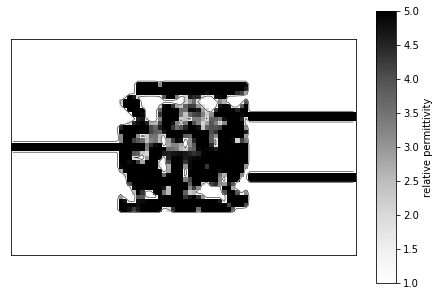

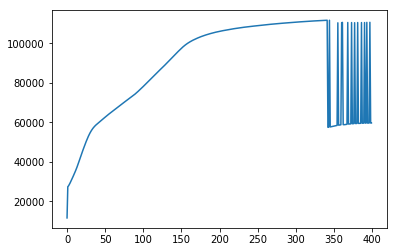

In [73]:
simulation.plt_eps()
plt.show()
plt.plot(obj_fns)
plt.show()

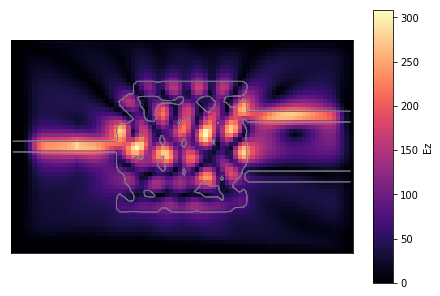

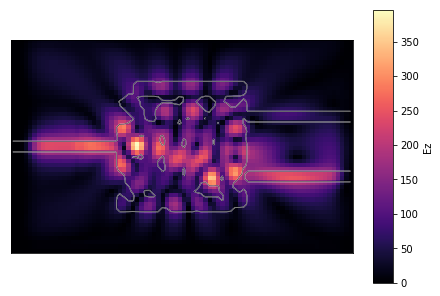

In [74]:
# compare the nonlinear and linear fields
(Hx,Hy,Ez) = simulation.solve_fields()
simulation.plt_abs()
(Hx_nl,Hy_nl,Ez_nl,_) = simulation.solve_fields_nl(nonlin_fns['deps_de'], regions['nonlin'],
                                                   dnl_de=kerr_nl_de,solver_nl='newton')
simulation.plt_abs()
plt.show()

Lastly I wanted to check the same thing using the Born solver. It's much worse.

In [76]:
simulation.reset_eps(eps_r)

# initialize an optimization object with the optimization-specific parameters
opt_both = Optimization(Nsteps=400, J=J, dJdE=dJdE, eps_max=5, step_size=.04, solver='born', opt_method='adam')

# run that optimization with the simulation and your objective function stuff
(new_eps, obj_fns) = opt_both.run(simulation, regions=regions, nonlin_fns=nonlin_fns)

  0% (2 of 400) |                        | Elapsed Time: 0:00:01 ETA:   0:04:48

the simulation did not converge, reached 0.5999376681524412


 33% (133 of 400) |#######               | Elapsed Time: 0:01:42 ETA:   0:06:04

the simulation did not converge, reached 1.2288955222662658e-10


 33% (134 of 400) |#######               | Elapsed Time: 0:01:44 ETA:   0:06:04

the simulation did not converge, reached 1.8647428640755621e-10


 33% (135 of 400) |#######               | Elapsed Time: 0:01:45 ETA:   0:06:13

the simulation did not converge, reached 2.8541508392303965e-10


 34% (136 of 400) |#######               | Elapsed Time: 0:01:47 ETA:   0:06:26

the simulation did not converge, reached 4.34117018502098e-10


 34% (137 of 400) |#######               | Elapsed Time: 0:01:48 ETA:   0:06:33

the simulation did not converge, reached 6.583013929973088e-10


 34% (138 of 400) |#######               | Elapsed Time: 0:01:50 ETA:   0:06:37

the simulation did not converge, reached 9.999459472151623e-10


 34% (139 of 400) |#######               | Elapsed Time: 0:01:51 ETA:   0:06:30

the simulation did not converge, reached 1.5369924566904176e-09


 35% (140 of 400) |#######               | Elapsed Time: 0:01:53 ETA:   0:06:52

the simulation did not converge, reached 2.3865315753981515e-09


 35% (141 of 400) |#######               | Elapsed Time: 0:01:55 ETA:   0:09:01

the simulation did not converge, reached 3.6649059845264884e-09


 35% (142 of 400) |#######               | Elapsed Time: 0:01:56 ETA:   0:07:38

the simulation did not converge, reached 5.575974046606732e-09


 35% (143 of 400) |#######               | Elapsed Time: 0:01:58 ETA:   0:06:09

the simulation did not converge, reached 8.4109996143646e-09


 36% (144 of 400) |#######               | Elapsed Time: 0:01:59 ETA:   0:06:24

the simulation did not converge, reached 1.2520664761715741e-08


 36% (145 of 400) |#######               | Elapsed Time: 0:02:01 ETA:   0:06:56

the simulation did not converge, reached 1.809182283776854e-08


 36% (146 of 400) |########              | Elapsed Time: 0:02:03 ETA:   0:07:14

the simulation did not converge, reached 2.5864258735226248e-08


 36% (147 of 400) |########              | Elapsed Time: 0:02:04 ETA:   0:06:40

the simulation did not converge, reached 3.7216864623423996e-08


 37% (148 of 400) |########              | Elapsed Time: 0:02:06 ETA:   0:05:55

the simulation did not converge, reached 5.662080604584461e-08


 37% (149 of 400) |########              | Elapsed Time: 0:02:08 ETA:   0:10:27

the simulation did not converge, reached 8.310069298680331e-08


 37% (150 of 400) |########              | Elapsed Time: 0:02:10 ETA:   0:10:02

the simulation did not converge, reached 1.185023705583485e-07


 37% (151 of 400) |########              | Elapsed Time: 0:02:12 ETA:   0:09:02

the simulation did not converge, reached 1.6556998496388394e-07


 38% (152 of 400) |########              | Elapsed Time: 0:02:15 ETA:   0:09:16

the simulation did not converge, reached 2.2759984510710397e-07


 38% (153 of 400) |########              | Elapsed Time: 0:02:16 ETA:   0:07:43

the simulation did not converge, reached 3.109567486419563e-07


 38% (154 of 400) |########              | Elapsed Time: 0:02:18 ETA:   0:06:01

the simulation did not converge, reached 4.267858793272019e-07


 38% (155 of 400) |########              | Elapsed Time: 0:02:19 ETA:   0:05:50

the simulation did not converge, reached 6.080294205588459e-07


 39% (156 of 400) |########              | Elapsed Time: 0:02:21 ETA:   0:06:11

the simulation did not converge, reached 8.659339976518795e-07


 39% (157 of 400) |########              | Elapsed Time: 0:02:22 ETA:   0:06:32

the simulation did not converge, reached 1.2215732464950505e-06


 39% (158 of 400) |########              | Elapsed Time: 0:02:24 ETA:   0:06:09

the simulation did not converge, reached 1.7474589171144506e-06


 39% (159 of 400) |########              | Elapsed Time: 0:02:26 ETA:   0:06:35

the simulation did not converge, reached 2.557619233433918e-06


 40% (160 of 400) |########              | Elapsed Time: 0:02:28 ETA:   0:08:01

the simulation did not converge, reached 3.7378292293912908e-06


 40% (161 of 400) |########              | Elapsed Time: 0:02:29 ETA:   0:07:15

the simulation did not converge, reached 5.683226865758827e-06


 40% (162 of 400) |########              | Elapsed Time: 0:02:31 ETA:   0:06:36

the simulation did not converge, reached 9.125641424254078e-06


 40% (163 of 400) |########              | Elapsed Time: 0:02:33 ETA:   0:07:01

the simulation did not converge, reached 1.525981488462673e-05


 41% (164 of 400) |#########             | Elapsed Time: 0:02:35 ETA:   0:09:31

the simulation did not converge, reached 2.558812513767319e-05


 41% (165 of 400) |#########             | Elapsed Time: 0:02:38 ETA:   0:09:09

the simulation did not converge, reached 3.994377152721755e-05


 41% (166 of 400) |#########             | Elapsed Time: 0:02:40 ETA:   0:11:04

the simulation did not converge, reached 5.984122528089477e-05


 41% (167 of 400) |#########             | Elapsed Time: 0:02:42 ETA:   0:08:12

the simulation did not converge, reached 8.705808104522288e-05


 42% (168 of 400) |#########             | Elapsed Time: 0:02:44 ETA:   0:07:48

the simulation did not converge, reached 0.00012324958721766192


 42% (169 of 400) |#########             | Elapsed Time: 0:02:47 ETA:   0:10:50

the simulation did not converge, reached 0.00017176576602833323


 42% (170 of 400) |#########             | Elapsed Time: 0:02:49 ETA:   0:07:41

the simulation did not converge, reached 0.00023478810089646598


 42% (171 of 400) |#########             | Elapsed Time: 0:02:51 ETA:   0:06:52

the simulation did not converge, reached 0.00032269283852623496


 43% (172 of 400) |#########             | Elapsed Time: 0:02:53 ETA:   0:06:21

the simulation did not converge, reached 0.000456011001829108


 43% (173 of 400) |#########             | Elapsed Time: 0:02:54 ETA:   0:06:43

the simulation did not converge, reached 0.0006850638517677235


 43% (174 of 400) |#########             | Elapsed Time: 0:02:56 ETA:   0:06:05

the simulation did not converge, reached 0.001062170234120391


 43% (175 of 400) |#########             | Elapsed Time: 0:02:57 ETA:   0:05:25

the simulation did not converge, reached 0.0015951637361275508


 44% (176 of 400) |#########             | Elapsed Time: 0:02:59 ETA:   0:05:16

the simulation did not converge, reached 0.0022988917165894128


 44% (177 of 400) |#########             | Elapsed Time: 0:03:00 ETA:   0:05:29

the simulation did not converge, reached 0.0031922642725292867


 44% (178 of 400) |#########             | Elapsed Time: 0:03:02 ETA:   0:06:22

the simulation did not converge, reached 0.0043935077904585975


 44% (179 of 400) |#########             | Elapsed Time: 0:03:04 ETA:   0:06:15

the simulation did not converge, reached 0.006019615461261167


 45% (180 of 400) |#########             | Elapsed Time: 0:03:05 ETA:   0:05:35

the simulation did not converge, reached 0.008212999543324193


 45% (181 of 400) |#########             | Elapsed Time: 0:03:07 ETA:   0:05:46

the simulation did not converge, reached 0.011120265462617698


 45% (182 of 400) |##########            | Elapsed Time: 0:03:09 ETA:   0:06:37

the simulation did not converge, reached 0.014890610094878427


 45% (183 of 400) |##########            | Elapsed Time: 0:03:11 ETA:   0:06:48

the simulation did not converge, reached 0.019447067121828886


 46% (184 of 400) |##########            | Elapsed Time: 0:03:12 ETA:   0:05:45

the simulation did not converge, reached 0.02567044105861054


 46% (185 of 400) |##########            | Elapsed Time: 0:03:13 ETA:   0:05:13

the simulation did not converge, reached 0.03462624430779403


 46% (186 of 400) |##########            | Elapsed Time: 0:03:15 ETA:   0:05:29

the simulation did not converge, reached 0.048946835653361345


 46% (187 of 400) |##########            | Elapsed Time: 0:03:17 ETA:   0:05:30

the simulation did not converge, reached 0.07102292301244449


 47% (188 of 400) |##########            | Elapsed Time: 0:03:18 ETA:   0:05:26

the simulation did not converge, reached 0.1025181165027676


 47% (189 of 400) |##########            | Elapsed Time: 0:03:20 ETA:   0:05:49

the simulation did not converge, reached 0.14807367154334233


 47% (190 of 400) |##########            | Elapsed Time: 0:03:22 ETA:   0:05:58

the simulation did not converge, reached 0.21096460406703788


 47% (191 of 400) |##########            | Elapsed Time: 0:03:23 ETA:   0:05:24

the simulation did not converge, reached 0.2899520883676641


 48% (192 of 400) |##########            | Elapsed Time: 0:03:24 ETA:   0:04:50

the simulation did not converge, reached 0.37592072999567205


 48% (193 of 400) |##########            | Elapsed Time: 0:03:26 ETA:   0:04:46

the simulation did not converge, reached 0.4569686455009602


 48% (194 of 400) |##########            | Elapsed Time: 0:03:27 ETA:   0:04:44

the simulation did not converge, reached 0.5228386473856947


 48% (195 of 400) |##########            | Elapsed Time: 0:03:29 ETA:   0:04:49

the simulation did not converge, reached 0.5204911418580896


 49% (196 of 400) |##########            | Elapsed Time: 0:03:30 ETA:   0:05:29

the simulation did not converge, reached 0.6439118968370904


 49% (197 of 400) |##########            | Elapsed Time: 0:03:32 ETA:   0:06:07

the simulation did not converge, reached 0.6668749480386611


 49% (198 of 400) |##########            | Elapsed Time: 0:03:34 ETA:   0:06:02

the simulation did not converge, reached 0.4461294458302458


 49% (199 of 400) |##########            | Elapsed Time: 0:03:36 ETA:   0:07:43

the simulation did not converge, reached 0.7211567679378117


 50% (200 of 400) |###########           | Elapsed Time: 0:03:39 ETA:   0:07:32

the simulation did not converge, reached 0.739822852679147


 50% (201 of 400) |###########           | Elapsed Time: 0:03:41 ETA:   0:08:13

the simulation did not converge, reached 0.644027541349121


 50% (202 of 400) |###########           | Elapsed Time: 0:03:43 ETA:   0:07:40

the simulation did not converge, reached 0.7671595910340763


 50% (203 of 400) |###########           | Elapsed Time: 0:03:46 ETA:   0:07:33

the simulation did not converge, reached 0.7141629635809245


 51% (204 of 400) |###########           | Elapsed Time: 0:03:48 ETA:   0:06:47

the simulation did not converge, reached 0.7774233048268615


 51% (205 of 400) |###########           | Elapsed Time: 0:03:50 ETA:   0:08:08

the simulation did not converge, reached 0.6926040298744769


 51% (206 of 400) |###########           | Elapsed Time: 0:03:52 ETA:   0:06:29

the simulation did not converge, reached 0.781941402296867


 51% (207 of 400) |###########           | Elapsed Time: 0:03:54 ETA:   0:05:56

the simulation did not converge, reached 0.7418141468967784


 52% (208 of 400) |###########           | Elapsed Time: 0:03:55 ETA:   0:05:08

the simulation did not converge, reached 0.70052121621202


 52% (209 of 400) |###########           | Elapsed Time: 0:03:57 ETA:   0:04:41

the simulation did not converge, reached 0.779999350759399


 52% (210 of 400) |###########           | Elapsed Time: 0:03:58 ETA:   0:04:25

the simulation did not converge, reached 0.7282694043629441


 52% (211 of 400) |###########           | Elapsed Time: 0:04:00 ETA:   0:04:29

the simulation did not converge, reached 0.7019315194500929


 53% (212 of 400) |###########           | Elapsed Time: 0:04:01 ETA:   0:04:31

the simulation did not converge, reached 0.7569212919163768


 53% (213 of 400) |###########           | Elapsed Time: 0:04:03 ETA:   0:04:22

the simulation did not converge, reached 0.7415967042585458


 53% (214 of 400) |###########           | Elapsed Time: 0:04:04 ETA:   0:04:22

the simulation did not converge, reached 0.7036875743423486


 53% (215 of 400) |###########           | Elapsed Time: 0:04:05 ETA:   0:04:18

the simulation did not converge, reached 0.7168140984779561


 54% (216 of 400) |###########           | Elapsed Time: 0:04:07 ETA:   0:04:15

the simulation did not converge, reached 0.7444953923677418


 54% (217 of 400) |###########           | Elapsed Time: 0:04:08 ETA:   0:04:12

the simulation did not converge, reached 0.733938539949339


 54% (218 of 400) |###########           | Elapsed Time: 0:04:09 ETA:   0:04:10

the simulation did not converge, reached 0.7206119854496372


 54% (219 of 400) |############          | Elapsed Time: 0:04:11 ETA:   0:04:15

the simulation did not converge, reached 0.7288497251188369


 55% (220 of 400) |############          | Elapsed Time: 0:04:12 ETA:   0:04:11

the simulation did not converge, reached 0.7584388359117706


 55% (221 of 400) |############          | Elapsed Time: 0:04:14 ETA:   0:04:06

the simulation did not converge, reached 0.7812179767274084


 55% (222 of 400) |############          | Elapsed Time: 0:04:15 ETA:   0:04:07

the simulation did not converge, reached 0.784186322796951


 55% (223 of 400) |############          | Elapsed Time: 0:04:16 ETA:   0:04:05

the simulation did not converge, reached 0.7814574812056659


 56% (224 of 400) |############          | Elapsed Time: 0:04:18 ETA:   0:04:03

the simulation did not converge, reached 0.7951085236468813


 56% (225 of 400) |############          | Elapsed Time: 0:04:19 ETA:   0:04:05

the simulation did not converge, reached 0.8180947895033679


 56% (226 of 400) |############          | Elapsed Time: 0:04:21 ETA:   0:04:04

the simulation did not converge, reached 0.8216595687878039


 56% (227 of 400) |############          | Elapsed Time: 0:04:22 ETA:   0:04:00

the simulation did not converge, reached 0.808822346861261


 56% (228 of 400) |############          | Elapsed Time: 0:04:23 ETA:   0:03:57

the simulation did not converge, reached 0.8016170293362287


 57% (229 of 400) |############          | Elapsed Time: 0:04:25 ETA:   0:03:55

the simulation did not converge, reached 0.827061792378928


 57% (230 of 400) |############          | Elapsed Time: 0:04:26 ETA:   0:03:55

the simulation did not converge, reached 0.8006731346461538


 57% (231 of 400) |############          | Elapsed Time: 0:04:28 ETA:   0:03:52

the simulation did not converge, reached 0.8060867966858979


 57% (232 of 400) |############          | Elapsed Time: 0:04:29 ETA:   0:03:50

the simulation did not converge, reached 0.829931257933315


 58% (233 of 400) |############          | Elapsed Time: 0:04:30 ETA:   0:03:50

the simulation did not converge, reached 0.7999832151284901


 58% (234 of 400) |############          | Elapsed Time: 0:04:32 ETA:   0:03:47

the simulation did not converge, reached 0.8225882948689112


 58% (235 of 400) |############          | Elapsed Time: 0:04:33 ETA:   0:03:44

the simulation did not converge, reached 0.8194351045533219


 59% (236 of 400) |############          | Elapsed Time: 0:04:34 ETA:   0:03:45

the simulation did not converge, reached 0.8135179940305028


 59% (237 of 400) |#############         | Elapsed Time: 0:04:36 ETA:   0:03:48

the simulation did not converge, reached 0.8484908933223956


 59% (238 of 400) |#############         | Elapsed Time: 0:04:37 ETA:   0:03:48

the simulation did not converge, reached 0.735490287498428


 59% (239 of 400) |#############         | Elapsed Time: 0:04:39 ETA:   0:03:43

the simulation did not converge, reached 0.9583664936684138


 60% (240 of 400) |#############         | Elapsed Time: 0:04:40 ETA:   0:03:42

the simulation did not converge, reached 0.9313548964788492


 60% (241 of 400) |#############         | Elapsed Time: 0:04:41 ETA:   0:03:39

the simulation did not converge, reached 0.55658471414645


 60% (242 of 400) |#############         | Elapsed Time: 0:04:43 ETA:   0:03:39

the simulation did not converge, reached 1.0148829148068983


 60% (243 of 400) |#############         | Elapsed Time: 0:04:44 ETA:   0:03:38

the simulation did not converge, reached 0.9318643628449402


 61% (244 of 400) |#############         | Elapsed Time: 0:04:46 ETA:   0:03:35

the simulation did not converge, reached 0.8737848526880594


 61% (245 of 400) |#############         | Elapsed Time: 0:04:47 ETA:   0:03:37

the simulation did not converge, reached 0.8778487526319457


 61% (246 of 400) |#############         | Elapsed Time: 0:04:48 ETA:   0:03:41

the simulation did not converge, reached 0.8963418177883976


 61% (247 of 400) |#############         | Elapsed Time: 0:04:50 ETA:   0:03:39

the simulation did not converge, reached 0.9201368927183363


 62% (248 of 400) |#############         | Elapsed Time: 0:04:51 ETA:   0:03:47

the simulation did not converge, reached 0.9329471614423678


 62% (249 of 400) |#############         | Elapsed Time: 0:04:53 ETA:   0:04:23

the simulation did not converge, reached 0.916364896070618


 62% (250 of 400) |#############         | Elapsed Time: 0:04:55 ETA:   0:04:44

the simulation did not converge, reached 0.8716296545865908


 62% (251 of 400) |#############         | Elapsed Time: 0:04:58 ETA:   0:06:18

the simulation did not converge, reached 0.8094533289295583


 63% (252 of 400) |#############         | Elapsed Time: 0:05:00 ETA:   0:05:20

the simulation did not converge, reached 0.7498583987256395


 63% (253 of 400) |#############         | Elapsed Time: 0:05:02 ETA:   0:04:53

the simulation did not converge, reached 0.7153233158212035


 63% (254 of 400) |#############         | Elapsed Time: 0:05:03 ETA:   0:04:12

the simulation did not converge, reached 0.48259868830565006


 63% (255 of 400) |##############        | Elapsed Time: 0:05:05 ETA:   0:03:48

the simulation did not converge, reached 0.46542745714387757


 64% (256 of 400) |##############        | Elapsed Time: 0:05:06 ETA:   0:03:46

the simulation did not converge, reached 0.5441678507344033


 64% (257 of 400) |##############        | Elapsed Time: 0:05:08 ETA:   0:03:35

the simulation did not converge, reached 0.5513269464001982


 64% (258 of 400) |##############        | Elapsed Time: 0:05:09 ETA:   0:03:13

the simulation did not converge, reached 0.5196069782330943


 64% (259 of 400) |##############        | Elapsed Time: 0:05:11 ETA:   0:03:10

the simulation did not converge, reached 0.8008751360379837


 65% (260 of 400) |##############        | Elapsed Time: 0:05:12 ETA:   0:03:09

the simulation did not converge, reached 0.5518914097001351


 65% (261 of 400) |##############        | Elapsed Time: 0:05:13 ETA:   0:03:07

the simulation did not converge, reached 0.5406054321041537


 65% (262 of 400) |##############        | Elapsed Time: 0:05:15 ETA:   0:03:07

the simulation did not converge, reached 0.6222169407446727


 65% (263 of 400) |##############        | Elapsed Time: 0:05:16 ETA:   0:03:06

the simulation did not converge, reached 0.9472704529336244


 66% (264 of 400) |##############        | Elapsed Time: 0:05:17 ETA:   0:03:03

the simulation did not converge, reached 0.635984247624787


 66% (265 of 400) |##############        | Elapsed Time: 0:05:19 ETA:   0:03:01

the simulation did not converge, reached 0.9761879193045274


 66% (266 of 400) |##############        | Elapsed Time: 0:05:20 ETA:   0:03:12

the simulation did not converge, reached 1.024460286965708


 66% (267 of 400) |##############        | Elapsed Time: 0:05:22 ETA:   0:03:29

the simulation did not converge, reached 0.8314250719278398


 67% (268 of 400) |##############        | Elapsed Time: 0:05:23 ETA:   0:03:24

the simulation did not converge, reached 0.7122894534954258


 67% (269 of 400) |##############        | Elapsed Time: 0:05:25 ETA:   0:03:06

the simulation did not converge, reached 0.690527687457436


 67% (270 of 400) |##############        | Elapsed Time: 0:05:26 ETA:   0:03:09

the simulation did not converge, reached 0.7480681531683948


 67% (271 of 400) |##############        | Elapsed Time: 0:05:28 ETA:   0:04:24

the simulation did not converge, reached 1.0344378712381674


 68% (272 of 400) |##############        | Elapsed Time: 0:05:30 ETA:   0:04:00

the simulation did not converge, reached 0.9703618473164914


 68% (273 of 400) |###############       | Elapsed Time: 0:05:32 ETA:   0:03:39

the simulation did not converge, reached 0.6278008184726009


 68% (274 of 400) |###############       | Elapsed Time: 0:05:34 ETA:   0:03:45

the simulation did not converge, reached 0.6057859091125736


 68% (275 of 400) |###############       | Elapsed Time: 0:05:35 ETA:   0:03:32

the simulation did not converge, reached 0.5958598779682183


 69% (276 of 400) |###############       | Elapsed Time: 0:05:37 ETA:   0:03:17

the simulation did not converge, reached 0.911398146318149


 69% (277 of 400) |###############       | Elapsed Time: 0:05:38 ETA:   0:03:08

the simulation did not converge, reached 0.6687027755951572


 69% (278 of 400) |###############       | Elapsed Time: 0:05:40 ETA:   0:02:59

the simulation did not converge, reached 0.6054560624642936


 69% (279 of 400) |###############       | Elapsed Time: 0:05:41 ETA:   0:02:53

the simulation did not converge, reached 1.151627152025612


 70% (280 of 400) |###############       | Elapsed Time: 0:05:43 ETA:   0:02:57

the simulation did not converge, reached 0.4974550265474101


 70% (281 of 400) |###############       | Elapsed Time: 0:05:44 ETA:   0:03:02

the simulation did not converge, reached 0.5146356837765693


 70% (282 of 400) |###############       | Elapsed Time: 0:05:46 ETA:   0:02:49

the simulation did not converge, reached 0.8493655158801613


 70% (283 of 400) |###############       | Elapsed Time: 0:05:47 ETA:   0:02:47

the simulation did not converge, reached 1.063634940613536


 71% (284 of 400) |###############       | Elapsed Time: 0:05:49 ETA:   0:02:56

the simulation did not converge, reached 0.46229396111747767


 71% (285 of 400) |###############       | Elapsed Time: 0:05:50 ETA:   0:02:55

the simulation did not converge, reached 0.6788358154567256


 71% (286 of 400) |###############       | Elapsed Time: 0:05:52 ETA:   0:03:09

the simulation did not converge, reached 0.4414328334810448


 71% (287 of 400) |###############       | Elapsed Time: 0:05:53 ETA:   0:03:01

the simulation did not converge, reached 1.1167079124388204


 72% (288 of 400) |###############       | Elapsed Time: 0:05:55 ETA:   0:02:32

the simulation did not converge, reached 0.6862603548087706


 72% (289 of 400) |###############       | Elapsed Time: 0:05:56 ETA:   0:02:30

the simulation did not converge, reached 1.0478203278428617


 72% (290 of 400) |###############       | Elapsed Time: 0:05:57 ETA:   0:02:27

the simulation did not converge, reached 0.3975867455078879


 72% (291 of 400) |################      | Elapsed Time: 0:05:59 ETA:   0:02:25

the simulation did not converge, reached 0.5944418893541986


 73% (292 of 400) |################      | Elapsed Time: 0:06:00 ETA:   0:02:24

the simulation did not converge, reached 0.7301776531616115


 73% (293 of 400) |################      | Elapsed Time: 0:06:02 ETA:   0:02:46

the simulation did not converge, reached 0.3783773596618689


 73% (294 of 400) |################      | Elapsed Time: 0:06:03 ETA:   0:02:52

the simulation did not converge, reached 0.49072077970158323


 73% (295 of 400) |################      | Elapsed Time: 0:06:05 ETA:   0:02:35

the simulation did not converge, reached 0.4382813582994386


 74% (296 of 400) |################      | Elapsed Time: 0:06:06 ETA:   0:02:30

the simulation did not converge, reached 0.9995434600674139


 74% (297 of 400) |################      | Elapsed Time: 0:06:08 ETA:   0:02:38

the simulation did not converge, reached 0.7533476253877885


 74% (298 of 400) |################      | Elapsed Time: 0:06:10 ETA:   0:02:56

the simulation did not converge, reached 0.4242807131261576


 74% (299 of 400) |################      | Elapsed Time: 0:06:11 ETA:   0:02:51

the simulation did not converge, reached 1.0965148836428769


 75% (300 of 400) |################      | Elapsed Time: 0:06:13 ETA:   0:02:28

the simulation did not converge, reached 0.9935233925452267


 75% (301 of 400) |################      | Elapsed Time: 0:06:14 ETA:   0:02:16

the simulation did not converge, reached 1.0440376851848696


 75% (302 of 400) |################      | Elapsed Time: 0:06:16 ETA:   0:02:24

the simulation did not converge, reached 1.0056775573799241


 75% (303 of 400) |################      | Elapsed Time: 0:06:17 ETA:   0:02:28

the simulation did not converge, reached 0.5557710223384202


 76% (304 of 400) |################      | Elapsed Time: 0:06:18 ETA:   0:02:20

the simulation did not converge, reached 0.5773721299464553


 76% (305 of 400) |################      | Elapsed Time: 0:06:20 ETA:   0:02:17

the simulation did not converge, reached 0.7378419831047803


 76% (306 of 400) |################      | Elapsed Time: 0:06:21 ETA:   0:02:19

the simulation did not converge, reached 0.9544119946821334


 76% (307 of 400) |################      | Elapsed Time: 0:06:23 ETA:   0:02:22

the simulation did not converge, reached 0.8735406205484333


 77% (308 of 400) |################      | Elapsed Time: 0:06:24 ETA:   0:02:18

the simulation did not converge, reached 0.582754063342326


 77% (309 of 400) |################      | Elapsed Time: 0:06:26 ETA:   0:02:11

the simulation did not converge, reached 0.5595933111150966


 77% (310 of 400) |#################     | Elapsed Time: 0:06:27 ETA:   0:02:04

the simulation did not converge, reached 0.5974344352994858


 77% (311 of 400) |#################     | Elapsed Time: 0:06:29 ETA:   0:02:11

the simulation did not converge, reached 0.8529740023887258


 78% (312 of 400) |#################     | Elapsed Time: 0:06:30 ETA:   0:02:11

the simulation did not converge, reached 0.9966225499837412


 78% (313 of 400) |#################     | Elapsed Time: 0:06:32 ETA:   0:02:06

the simulation did not converge, reached 1.024905800952024


 78% (314 of 400) |#################     | Elapsed Time: 0:06:33 ETA:   0:02:04

the simulation did not converge, reached 0.9485748729947413


 78% (315 of 400) |#################     | Elapsed Time: 0:06:34 ETA:   0:01:56

the simulation did not converge, reached 0.6834596552565723


 79% (316 of 400) |#################     | Elapsed Time: 0:06:36 ETA:   0:01:55

the simulation did not converge, reached 0.5877687040264853


 79% (317 of 400) |#################     | Elapsed Time: 0:06:37 ETA:   0:01:54

the simulation did not converge, reached 0.5861194933987044


 79% (318 of 400) |#################     | Elapsed Time: 0:06:39 ETA:   0:01:53

the simulation did not converge, reached 0.576274170034003


 79% (319 of 400) |#################     | Elapsed Time: 0:06:40 ETA:   0:01:59

the simulation did not converge, reached 0.6225536814988266


 80% (320 of 400) |#################     | Elapsed Time: 0:06:42 ETA:   0:02:03

the simulation did not converge, reached 0.577020926977537


 80% (321 of 400) |#################     | Elapsed Time: 0:06:44 ETA:   0:02:15

the simulation did not converge, reached 0.593558543547215


 80% (322 of 400) |#################     | Elapsed Time: 0:06:45 ETA:   0:02:13

the simulation did not converge, reached 0.6024892554040464


 80% (323 of 400) |#################     | Elapsed Time: 0:06:47 ETA:   0:01:54

the simulation did not converge, reached 0.5853927193671182


 81% (324 of 400) |#################     | Elapsed Time: 0:06:48 ETA:   0:01:59

the simulation did not converge, reached 0.5929118568514015


 81% (325 of 400) |#################     | Elapsed Time: 0:06:50 ETA:   0:01:59

the simulation did not converge, reached 0.6116038191735158


 81% (326 of 400) |#################     | Elapsed Time: 0:06:51 ETA:   0:01:51

the simulation did not converge, reached 0.590445717182448


 81% (327 of 400) |#################     | Elapsed Time: 0:06:53 ETA:   0:01:51

the simulation did not converge, reached 0.5749057034862546


 82% (328 of 400) |##################    | Elapsed Time: 0:06:55 ETA:   0:01:59

the simulation did not converge, reached 0.568978195355724


 82% (329 of 400) |##################    | Elapsed Time: 0:06:56 ETA:   0:02:03

the simulation did not converge, reached 0.5692004540425225


 82% (330 of 400) |##################    | Elapsed Time: 0:06:58 ETA:   0:01:50

the simulation did not converge, reached 0.5662032387074752


 82% (331 of 400) |##################    | Elapsed Time: 0:06:59 ETA:   0:01:39

the simulation did not converge, reached 0.5476508803140953


 83% (332 of 400) |##################    | Elapsed Time: 0:07:01 ETA:   0:01:42

the simulation did not converge, reached 0.5481259987555888


 83% (333 of 400) |##################    | Elapsed Time: 0:07:02 ETA:   0:01:42

the simulation did not converge, reached 0.5464451249341146


 83% (334 of 400) |##################    | Elapsed Time: 0:07:04 ETA:   0:01:35

the simulation did not converge, reached 0.5296511448510869


 83% (335 of 400) |##################    | Elapsed Time: 0:07:05 ETA:   0:01:35

the simulation did not converge, reached 0.522188882221766


 84% (336 of 400) |##################    | Elapsed Time: 0:07:07 ETA:   0:01:36

the simulation did not converge, reached 0.5443976540904961


 84% (337 of 400) |##################    | Elapsed Time: 0:07:08 ETA:   0:01:35

the simulation did not converge, reached 0.5858390861676809


 84% (338 of 400) |##################    | Elapsed Time: 0:07:10 ETA:   0:01:31

the simulation did not converge, reached 0.5576417051312147


 84% (339 of 400) |##################    | Elapsed Time: 0:07:11 ETA:   0:01:33

the simulation did not converge, reached 0.5280870982371332


 85% (340 of 400) |##################    | Elapsed Time: 0:07:13 ETA:   0:01:29

the simulation did not converge, reached 0.5595965433787284


 85% (341 of 400) |##################    | Elapsed Time: 0:07:14 ETA:   0:01:23

the simulation did not converge, reached 0.687002162168428


 85% (342 of 400) |##################    | Elapsed Time: 0:07:16 ETA:   0:01:29

the simulation did not converge, reached 0.6984611244781833


 85% (343 of 400) |##################    | Elapsed Time: 0:07:17 ETA:   0:01:35

the simulation did not converge, reached 0.9862907431087105


 86% (344 of 400) |##################    | Elapsed Time: 0:07:19 ETA:   0:01:30

the simulation did not converge, reached 1.0052144945408426


 86% (345 of 400) |##################    | Elapsed Time: 0:07:21 ETA:   0:01:25

the simulation did not converge, reached 0.6816978511095816


 86% (346 of 400) |###################   | Elapsed Time: 0:07:22 ETA:   0:01:24

the simulation did not converge, reached 0.45711393805344064


 86% (347 of 400) |###################   | Elapsed Time: 0:07:24 ETA:   0:01:20

the simulation did not converge, reached 0.8136195904603175


 87% (348 of 400) |###################   | Elapsed Time: 0:07:25 ETA:   0:01:14

the simulation did not converge, reached 0.6559992708226656


 87% (349 of 400) |###################   | Elapsed Time: 0:07:26 ETA:   0:01:08

the simulation did not converge, reached 0.7272014280811384


 87% (350 of 400) |###################   | Elapsed Time: 0:07:28 ETA:   0:01:10

the simulation did not converge, reached 1.2376201332310066


 87% (351 of 400) |###################   | Elapsed Time: 0:07:29 ETA:   0:01:11

the simulation did not converge, reached 0.6682228697632215


 88% (352 of 400) |###################   | Elapsed Time: 0:07:32 ETA:   0:01:48

the simulation did not converge, reached 0.8404581142863092


 88% (353 of 400) |###################   | Elapsed Time: 0:07:33 ETA:   0:01:33

the simulation did not converge, reached 0.8812527524711302


 88% (354 of 400) |###################   | Elapsed Time: 0:07:35 ETA:   0:01:11

the simulation did not converge, reached 0.9099965356663138


 88% (355 of 400) |###################   | Elapsed Time: 0:07:36 ETA:   0:01:04

the simulation did not converge, reached 0.9252834816493715


 89% (356 of 400) |###################   | Elapsed Time: 0:07:38 ETA:   0:01:13

the simulation did not converge, reached 0.9239796832202501


 89% (357 of 400) |###################   | Elapsed Time: 0:07:40 ETA:   0:01:14

the simulation did not converge, reached 0.906675531514487


 89% (358 of 400) |###################   | Elapsed Time: 0:07:41 ETA:   0:01:06

the simulation did not converge, reached 0.8763225724014738


 89% (359 of 400) |###################   | Elapsed Time: 0:07:43 ETA:   0:01:08

the simulation did not converge, reached 0.8412046204442926


 90% (360 of 400) |###################   | Elapsed Time: 0:07:45 ETA:   0:01:07

the simulation did not converge, reached 0.8163812562208842


 90% (361 of 400) |###################   | Elapsed Time: 0:07:46 ETA:   0:01:01

the simulation did not converge, reached 0.8090007499368581


 90% (362 of 400) |###################   | Elapsed Time: 0:07:48 ETA:   0:00:58

the simulation did not converge, reached 0.6321281684042606


 90% (363 of 400) |###################   | Elapsed Time: 0:07:50 ETA:   0:01:02

the simulation did not converge, reached 0.5934335720107827


 91% (364 of 400) |####################  | Elapsed Time: 0:07:51 ETA:   0:00:58

the simulation did not converge, reached 0.7037149949074749


 91% (365 of 400) |####################  | Elapsed Time: 0:07:52 ETA:   0:00:49

the simulation did not converge, reached 0.5855409123681274


 91% (366 of 400) |####################  | Elapsed Time: 0:07:54 ETA:   0:00:46

the simulation did not converge, reached 0.6712285278252227


 91% (367 of 400) |####################  | Elapsed Time: 0:07:55 ETA:   0:00:45

the simulation did not converge, reached 0.6478543843115536


 92% (368 of 400) |####################  | Elapsed Time: 0:07:57 ETA:   0:00:47

the simulation did not converge, reached 0.7884157808398553


 92% (369 of 400) |####################  | Elapsed Time: 0:07:58 ETA:   0:00:46

the simulation did not converge, reached 1.0518892129997275


 92% (370 of 400) |####################  | Elapsed Time: 0:08:00 ETA:   0:00:45

the simulation did not converge, reached 0.790399884250556


 92% (371 of 400) |####################  | Elapsed Time: 0:08:01 ETA:   0:00:47

the simulation did not converge, reached 0.7866647860268743


 93% (372 of 400) |####################  | Elapsed Time: 0:08:03 ETA:   0:00:47

the simulation did not converge, reached 0.6455915117400193


 93% (373 of 400) |####################  | Elapsed Time: 0:08:04 ETA:   0:00:42

the simulation did not converge, reached 0.701586535006451


 93% (374 of 400) |####################  | Elapsed Time: 0:08:06 ETA:   0:00:37

the simulation did not converge, reached 0.7995097482674968


 93% (375 of 400) |####################  | Elapsed Time: 0:08:07 ETA:   0:00:35

the simulation did not converge, reached 1.1996583768487419


 94% (376 of 400) |####################  | Elapsed Time: 0:08:09 ETA:   0:00:33

the simulation did not converge, reached 0.5018616417460844


 94% (377 of 400) |####################  | Elapsed Time: 0:08:10 ETA:   0:00:32

the simulation did not converge, reached 0.8461470922595302


 94% (378 of 400) |####################  | Elapsed Time: 0:08:12 ETA:   0:00:30

the simulation did not converge, reached 1.222066872820473


 94% (379 of 400) |####################  | Elapsed Time: 0:08:13 ETA:   0:00:28

the simulation did not converge, reached 0.7046556582861928


 95% (380 of 400) |####################  | Elapsed Time: 0:08:14 ETA:   0:00:27

the simulation did not converge, reached 1.250983547541362


 95% (381 of 400) |####################  | Elapsed Time: 0:08:16 ETA:   0:00:26

the simulation did not converge, reached 0.7169394936167653


 95% (382 of 400) |##################### | Elapsed Time: 0:08:17 ETA:   0:00:25

the simulation did not converge, reached 0.9132936677646121


 95% (383 of 400) |##################### | Elapsed Time: 0:08:19 ETA:   0:00:24

the simulation did not converge, reached 1.0156687710723589


 96% (384 of 400) |##################### | Elapsed Time: 0:08:20 ETA:   0:00:21

the simulation did not converge, reached 1.035847965881405


 96% (385 of 400) |##################### | Elapsed Time: 0:08:21 ETA:   0:00:20

the simulation did not converge, reached 1.0253026516506807


 96% (386 of 400) |##################### | Elapsed Time: 0:08:23 ETA:   0:00:19

the simulation did not converge, reached 0.9905729895040556


 96% (387 of 400) |##################### | Elapsed Time: 0:08:24 ETA:   0:00:17

the simulation did not converge, reached 0.9136343142424119


 97% (388 of 400) |##################### | Elapsed Time: 0:08:25 ETA:   0:00:16

the simulation did not converge, reached 0.5066360604831482


 97% (389 of 400) |##################### | Elapsed Time: 0:08:27 ETA:   0:00:14

the simulation did not converge, reached 0.6164674290365657


 97% (390 of 400) |##################### | Elapsed Time: 0:08:28 ETA:   0:00:13

the simulation did not converge, reached 0.6700161171609905


 97% (391 of 400) |##################### | Elapsed Time: 0:08:29 ETA:   0:00:12

the simulation did not converge, reached 0.4279977924945908


 98% (392 of 400) |##################### | Elapsed Time: 0:08:31 ETA:   0:00:10

the simulation did not converge, reached 0.6651663528924631


 98% (393 of 400) |##################### | Elapsed Time: 0:08:32 ETA:   0:00:09

the simulation did not converge, reached 0.8142210697944534


 98% (394 of 400) |##################### | Elapsed Time: 0:08:33 ETA:   0:00:08

the simulation did not converge, reached 0.5940825299964299


 98% (395 of 400) |##################### | Elapsed Time: 0:08:35 ETA:   0:00:06

the simulation did not converge, reached 0.5545873760481546


 99% (396 of 400) |##################### | Elapsed Time: 0:08:36 ETA:   0:00:05

the simulation did not converge, reached 0.5724136652970667


 99% (397 of 400) |##################### | Elapsed Time: 0:08:38 ETA:   0:00:04

the simulation did not converge, reached 0.7543617502733811


 99% (398 of 400) |##################### | Elapsed Time: 0:08:39 ETA:   0:00:02

the simulation did not converge, reached 0.4815783182586539


 99% (399 of 400) |##################### | Elapsed Time: 0:08:41 ETA:   0:00:01

the simulation did not converge, reached 0.927624846184601


100% (400 of 400) |######################| Elapsed Time: 0:08:42 ETA:  00:00:00

the simulation did not converge, reached 0.28692075447132387
the simulation did not converge, reached 0.5923850731814985


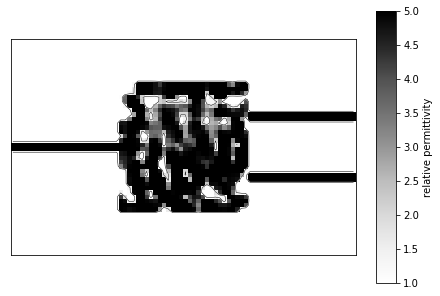

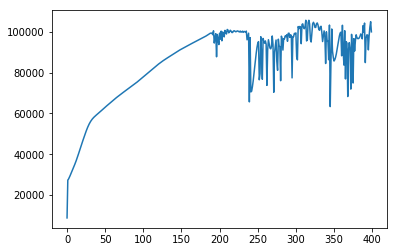

the simulation did not converge, reached 0.08278389535054236


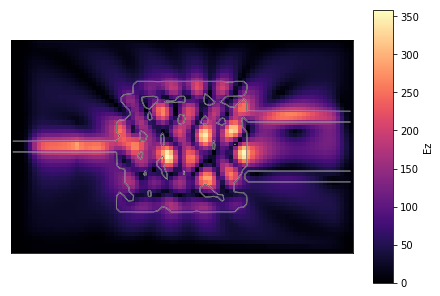

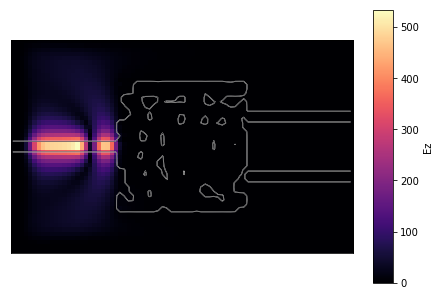

In [77]:
simulation.plt_eps()
plt.show()
plt.plot(obj_fns)
plt.show()
# compare the nonlinear and linear fields
(Hx,Hy,Ez) = simulation.solve_fields()
simulation.plt_abs()
(Hx_nl,Hy_nl,Ez_nl,_) = simulation.solve_fields_nl(nonlin_fns['deps_de'], regions['nonlin'],
                                                   dnl_de=kerr_nl_de,solver_nl='newton')
simulation.plt_abs()
plt.show()